In [1]:
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from psis import *

import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
df = pd.read_csv("../data/final_frame_non_imputed.csv")
df.dropna(inplace=True)
df

,Unnamed: 0,ACERECODE,OBEREGION,STRAT,STUDWGT,REASON05,REASON06,REASON08,REASON07,REASON10,...,ParentalIncome,Areyourparentsalive?divorced?,Fatherseducation,Motherseducation,Firstgenerationstatusbasedonparent(s)withlessthansomecollege,Fatherscareeraggregated,Motherscareeraggregated,Yourfathersreligiouspreference,Yourmothersreligiouspreference,Areyouaveteran?
0,0,2192,5.0,34,12.063300,3.0,3.0,2.0,3.0,3.0,...,12,0,1,2,0,1,1,3,3,0
1,5,2192,5.0,34,11.163551,3.0,3.0,2.0,3.0,1.0,...,10,0,6,6,0,15,15,3,3,0
2,17,2192,5.0,34,12.063300,3.0,3.0,3.0,3.0,3.0,...,13,0,4,8,1,15,10,3,3,0
3,19,2192,5.0,34,12.063300,3.0,3.0,3.0,3.0,3.0,...,8,1,6,2,0,1,15,1,1,0
4,23,2192,5.0,34,12.063300,2.0,2.0,2.0,2.0,2.0,...,12,0,4,6,0,17,19,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98577,262219,439,2.0,13,11.945652,3.0,3.0,3.0,3.0,2.0,...,8,2,4,3,1,15,15,2,2,0
98578,262220,439,2.0,13,9.875781,3.0,3.0,3.0,3.0,3.0,...,0,1,6,6,0,15,15,3,3,0
98579,262221,439,2.0,13,11.945652,3.0,3.0,3.0,3.0,3.0,...,2,1,8,8,1,15,15,3,3,0
98580,262222,439,2.0,13,9.875781,3.0,3.0,3.0,3.0,3.0,...,9,0,5,1,0,11,2,3,3,0


In [4]:
col_to_drop = [
'Unnamed: 0', 
'CHOICE',
'ACCPT1ST',
'DOBMonth',
'DOBYear',
'HowoldwillyoubeonDecember31ofthisyear?',
'HowoldwillyoubeonDecember31ofthisyear?2']
target = ["ACCPT1ST"]
X = df.drop(col_to_drop + target, axis=1).copy()
Y = df[target].replace({1:0, 2:1})

In [5]:
# Get dummy variables for school
X.drop(["ACERECODE", "State", "Race/EthnicityGroup", "Yoursex:"], axis=1, inplace=True)
df["ACERECODE"] = df["ACERECODE"].astype(np.int64)
dummy_school = pd.get_dummies(df["ACERECODE"], prefix="school")
dummy_state = pd.get_dummies(df["State"], prefix="", prefix_sep="")
dummy_race = pd.get_dummies(df["Race/EthnicityGroup"], prefix="", prefix_sep="")
dummy_gender = pd.get_dummies(df["Yoursex:"], prefix="", prefix_sep="")
X = pd.concat([X, dummy_school, dummy_state, dummy_race, dummy_gender], axis=1).copy()

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    X,
    Y,
    train_size=3_000,
    test_size=1_000,
    random_state=17)

In [6]:
# Convert dataframes to np arrays
X_train = X_train_df.copy().to_numpy()
X_test  = X_test_df.copy().to_numpy()
y_train = y_train_df.copy().astype(np.int8).to_numpy().flatten()
y_test = y_test_df.copy().astype(np.int8).to_numpy().flatten()

In [7]:

model_code = """
data {
    int<lower=1> n;                     // number of data points
    int<lower=1> d;                     // explanatory variable dimension
    matrix[n, d] X;                     // explanatory variable
    array[n] int <lower=0,upper=1> y;   // response variable
    int<lower=1> p_alpha_df;            // prior alpha degrees of freedom
    real p_alpha_loc;                   // prior alpha location
    real p_alpha_scale;                 // prior scale alpha
    int<lower=1> p_beta_df;             // prior beta degrees of freedom
    int<lower=1> p_beta_global_df;      // prior beta global degrees of freedom
    real p_beta_global_scale;           // prior beta global scale
    int<lower=0> N_test;                // number of test samples
    matrix[N_test, d] X_test;           // test data
}

parameters {

    // intercept
    real alpha;

    // auxiliary variables for the variance parameters
    vector[d] z;
    vector[d] lambda_r1;
    vector<lower=0>[d] lambda_r2;
    real tau_r1;
    real<lower=0> tau_r2;
}

transformed parameters {

    vector[d] lambda;           // local variance parameter
    real tau;                   // global variance parameter
    vector[d] beta;             // explanatory variable weights
    vector[n] eta;              // linear predictor

    lambda = lambda_r1 .* sqrt(lambda_r2);
    tau = tau_r1 * sqrt(tau_r2);
    beta = z .* (lambda*tau);
    eta = alpha + X * beta;
}

model {

    // student t prior for intercept
    alpha ~ student_t(p_alpha_df, p_alpha_loc, p_alpha_scale);

    z ~ normal(0.0, 1.0);

    // half t priors for lambdas
    lambda_r1 ~ normal(0.0, 1.0);
    lambda_r2 ~ inv_gamma(0.5*p_beta_df, 0.5*p_beta_df);

    // half t priors for tau
    tau_r1 ~ normal(0.0, p_beta_global_scale);
    tau_r2 ~ inv_gamma(0.5*p_beta_global_df, 0.5*p_beta_global_df);

    // observation model
    y ~ bernoulli_logit(eta);
}

generated quantities {
    // calculate the log likelihood
    vector[n] log_lik;
    for (i in 1:n)
        log_lik[i] = bernoulli_logit_lpmf(y[i] | eta[i]);

    // generate values for Y tilde
    array[n] int<lower=0, upper=1> Y_tilde;
    Y_tilde = bernoulli_logit_rng(eta);

    // Make predictions
    vector[N_test] y_test;
    for (j in 1:N_test) {
        y_test[j] = bernoulli_logit_rng(alpha + X_test[j] * beta);
    }
}
"""

In [8]:
n = X_train.shape[0]
d = X_train.shape[1]
# degf = d - 1
degf = 5
p0 = 200
tau0 = p0 / (d - p0) * (1/np.sqrt(n))
data_dict = dict(
    n=n,                # num data points
    d=d,                # num features
    X=X_train,                # data matrix  
    y=y_train,                # response variable
    p_alpha_df=degf,   # prior deg freedom for alpha
    p_alpha_loc=0,      # prior location for alpha
    p_alpha_scale=5,  # prior scale for alpha
    p_beta_df=degf,    # prior deg freedom for beta
    p_beta_global_df=degf,       # prior location for beta
    p_beta_global_scale=tau0,    # prior scale for beta
    N_test=X_test.shape[0],
    X_test=X_test
)

In [9]:
horseshoe_model = stan.build(model_code, data=data_dict)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [10]:
fit = horseshoe_model.sample()

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

In [11]:
az_fit = az.from_pystan(fit)

In [12]:
print(np.sum(az_fit.sample_stats["diverging"]))

<xarray.DataArray 'diverging' ()>
array(192)


In [13]:
summary_table = az.summary(az_fit, var_names=['alpha', 'beta'])
# col_labels = feature_cols + list(dummy_school.columns) + list(dummy_state.columns) + list(dummy_race.columns) + list(dummy_gender.columns)
# index_labels = ["intercept"] + col_labels
# summary_table.index = index_labels
# print(summary_table.to_latex())
summary_table

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.328,0.970,-1.510,2.098,0.018,0.015,2759.0,2736.0,1.0
beta[0],-0.001,0.027,-0.056,0.050,0.001,0.000,2662.0,3665.0,1.0
beta[1],0.018,0.011,-0.002,0.038,0.000,0.000,3135.0,3441.0,1.0
beta[2],0.011,0.042,-0.061,0.099,0.001,0.001,2201.0,1304.0,1.0
beta[3],-0.018,0.069,-0.170,0.109,0.001,0.001,2436.0,2600.0,1.0
...,...,...,...,...,...,...,...,...,...
beta[386],0.028,0.125,-0.206,0.292,0.003,0.002,1673.0,1914.0,1.0
beta[387],-0.002,0.078,-0.166,0.151,0.002,0.001,2039.0,1688.0,1.0
beta[388],0.030,0.073,-0.090,0.196,0.001,0.001,2336.0,2648.0,1.0
beta[389],0.114,0.129,-0.078,0.370,0.003,0.002,2038.0,2002.0,1.0


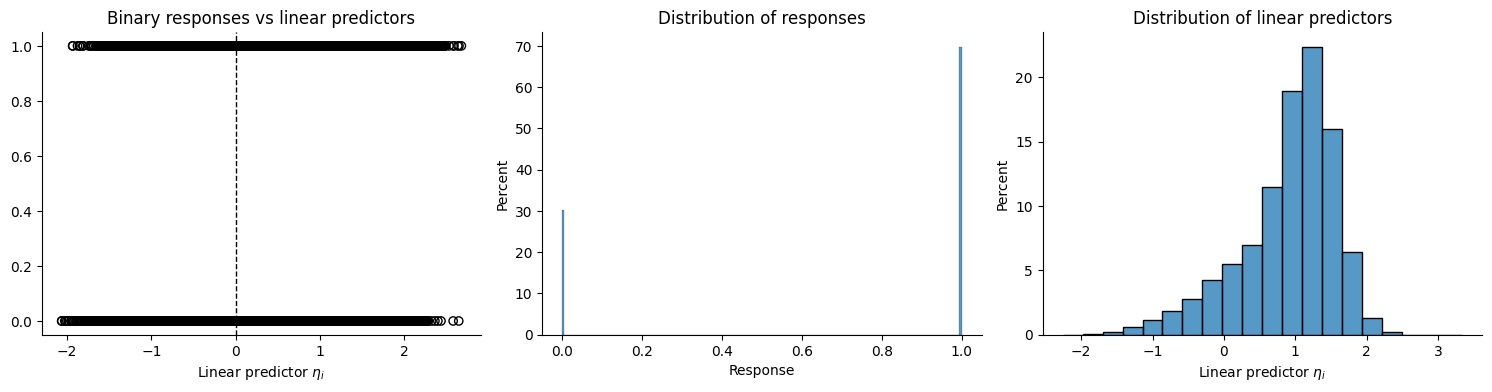

In [36]:
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.title('Binary responses vs linear predictors')
for sample_idx in range(10):
  # choose a random sample
  t = np.random.randint(0, 4000)
  plt.scatter(fit['eta'][:, t], fit['Y_tilde'][:, t], c='none', edgecolors='k')
sns.despine()
plt.axvline(0, c='k', lw=1, ls='--')
plt.xlabel('Linear predictor $\eta_i$')


plt.subplot(132)
plt.title('Distribution of responses')
sns.histplot(fit['Y_tilde'].flatten(), stat='percent')
sns.despine()
plt.xlabel('Response')

plt.subplot(133)
sns.histplot(fit['eta'].flatten(), bins=20, stat='percent')
sns.despine()
plt.xlabel('Linear predictor $\eta_i$')
plt.title('Distribution of linear predictors')

plt.tight_layout(pad=1)

In [14]:
az.loo(az_fit, pointwise=True)

Computed from 4000 by 3000 log-likelihood matrix

         Estimate       SE
elpd_loo -1281.24    29.49
p_loo       50.97        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3000  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [15]:
t = np.random.randint(0, 4000)
print(classification_report(y_test, fit["y_test"][:, t]))

              precision    recall  f1-score   support

           0       0.38      0.36      0.37       228
           1       0.81      0.83      0.82       772

    accuracy                           0.72      1000
   macro avg       0.60      0.59      0.59      1000
weighted avg       0.71      0.72      0.72      1000



In [17]:
with open("../stats/hs_posterior_betas_chris_not_imputed.txt", "w") as f:
    print(summary_table["mean"].to_string(), file=f)